# Load All Data

In [1]:
import pickle as pkl

with open('./data/4_compiled/2024-06-14-10-43-49.pkl', 'rb') as f:
    compiled_datas = pkl.load(f)

# Extract Keys

In [2]:
compiled_datas.keys()

dict_keys(['coarse', 'coarse_wide', 'fine', 'low_temp', 'near_T1', 'near_T2'])

In [3]:
for compiled_data in compiled_datas.values():
    print(compiled_data[list(compiled_data.keys())[0]].keys())

Index(['Time Stamp', 'Comment', 'System Status', 'Puck Temp', 'System Temp',
       'Field', 'Pressure', 'Sample Temp', 'Temp Rise', 'Samp HC',
       'Samp HC Err', 'Addenda HC', 'Addenda HC Err', 'Total HC',
       'Total HC Err', 'Fit Deviation', 'Time Const tau1', 'Time Const tau2',
       'Sample Coupling', 'Debye Temp', 'Debye Temp Err', 'Cal Correction',
       'Therm Resist', 'Htr Resist', 'Puck Resist', 'Wire Cond', 'Meas Time',
       'Temp Squared', 'Samp HC/Temp', 'Addenda Offset HC'],
      dtype='object')
Index(['Time Stamp', 'Comment', 'System Status', 'Puck Temp', 'System Temp',
       'Field', 'Pressure', 'Sample Temp', 'Temp Rise', 'Samp HC',
       'Samp HC Err', 'Addenda HC', 'Addenda HC Err', 'Total HC',
       'Total HC Err', 'Fit Deviation', 'Time Const tau1', 'Time Const tau2',
       'Sample Coupling', 'Debye Temp', 'Debye Temp Err', 'Cal Correction',
       'Therm Resist', 'Htr Resist', 'Puck Resist', 'Wire Cond', 'Meas Time',
       'Temp Squared', 'Samp HC/T

# Key Replacement

In [4]:
new_keys = ['T', 'C']
old_keyss = [['Sample Temp', 'Sample Temp (Kelvin)', 'Temperature'],
             ['Samp HC', 'Samp HC (uJ/K)', 'HCSample']]

In [5]:
datas = dict()
for key, compiled_data in compiled_datas.items():
    data = dict()
    for B, compiled_datum in compiled_data.items():
        compiled_keys = list(compiled_datum.keys())
        keys = []
        for old_keys in old_keyss:
            for old_key in old_keys:
                if old_key in compiled_keys:
                    keys.append(old_key)
        datum = compiled_datum[keys].rename(columns = dict(zip(keys, new_keys)), inplace = False)
        data[B] = datum.dropna()
    datas[key] = data

# Fit Phonon, and Electron Contribution on "coarse" data

In [6]:
coarse_wide_data = datas['coarse_wide']

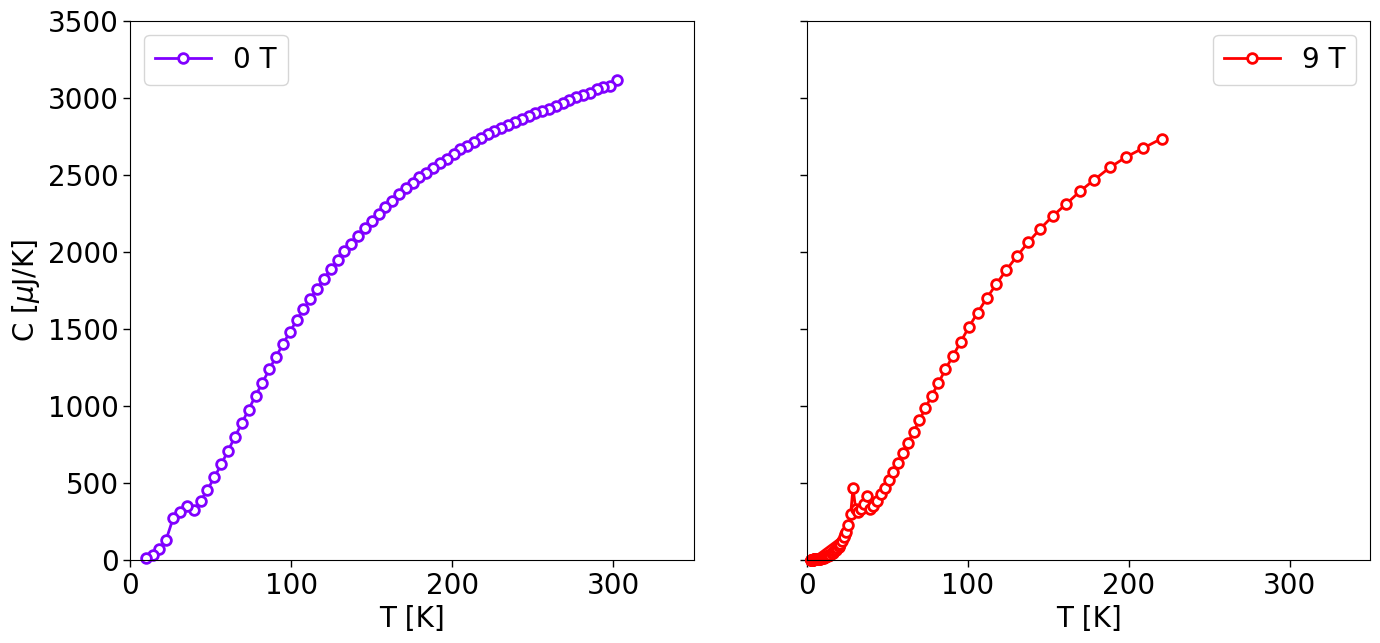

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

colors = mpl.colormaps['rainbow'](np.linspace(0, 1, 10))
fontsize = 20

fig, ax = plt.subplots(1, 2, figsize = (16, 7), sharey = True)
for i, (B, coarse_wide_datum) in enumerate(coarse_wide_data.items()):
    ax[i].plot(coarse_wide_datum['T'].dropna() , coarse_wide_datum['C'].dropna() , 'o-', 
            linewidth = 2, markersize = 7, markerfacecolor = 'w', markeredgewidth = 2,
            label = f'{B} T', clip_on = False, color = colors[B])
    ax[i].set_xlabel('T [K]', fontsize = fontsize)
    ax[i].tick_params(axis = 'both', length = 5, width = 1, labelsize = fontsize)
    ax[i].set_xlim(0, 350)
    ax[i].set_ylim(0, 3500)
    ax[i].legend(fontsize = fontsize)
ax[0].set_ylabel(r'C [$\mu$J/K]', fontsize = fontsize)
plt.show()

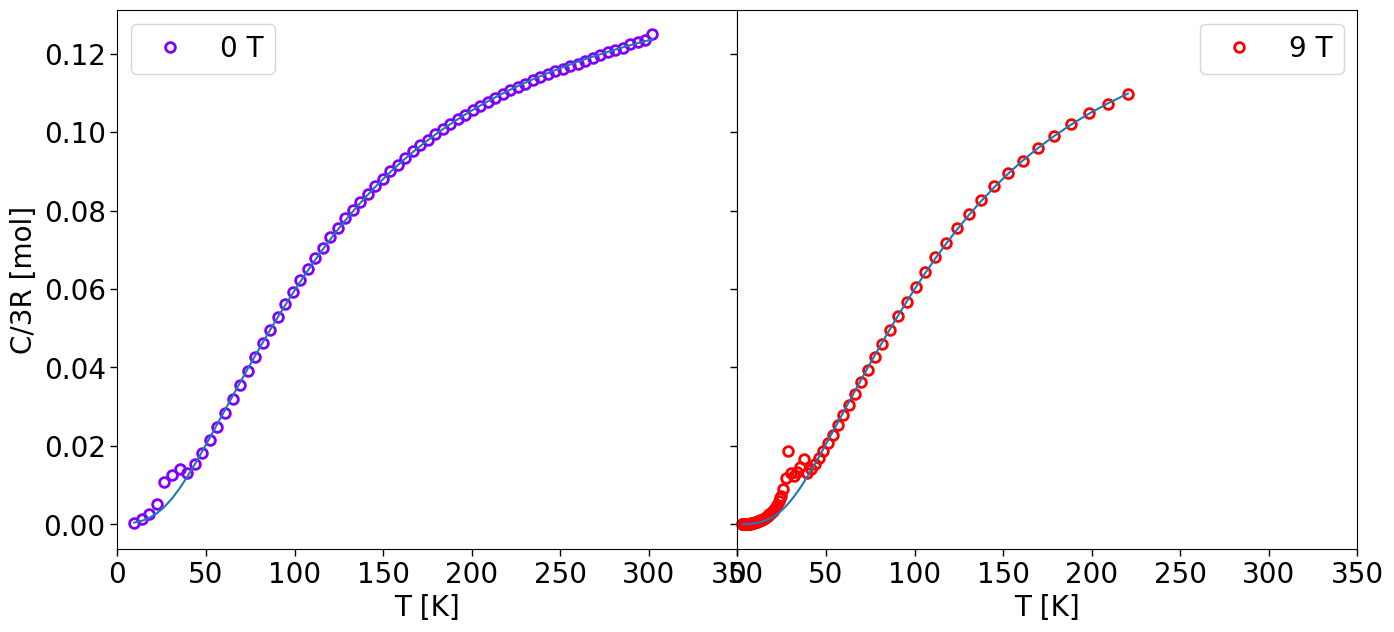

In [11]:
from scipy.optimize import least_squares
from fitting_functions import phonon_electron, residuals

func = np.vectorize(phonon_electron)

T_cutoff = 50

fig, ax = plt.subplots(1, 2, figsize = (16, 7), sharey = True)
for i, (B, coarse_wide_datum) in enumerate(coarse_wide_data.items()):
    coarse_wide_datum = coarse_wide_datum.sort_values(by=['T'])
    T = coarse_wide_datum['T'].to_numpy()
    c = coarse_wide_datum['C'].to_numpy()/(3*8314.5)
    weight = np.pad(T[2:] - T[:-2], pad_width = 1, mode = 'edge')
    weight /= np.max(weight)
    bounds = [[0, 0, 0, 100, 0],
              [0.1, 500, 0.1, 500, 0.001]]
    ps = least_squares(residuals, x0 = [0.1, 400, 0, 400, 0], bounds = bounds, args = (T, c, func, T_cutoff, 1000, weight))
    bg = func(T, *ps.x)
    ax[i].plot(T, c, 'o', 
        linewidth = 2, markersize = 7, markerfacecolor = 'none', markeredgewidth = 2,
        label = f'{B} T', clip_on = False, color = colors[B])
    ax[i].plot(T, bg)
    ax[i].set_xlabel('T [K]', fontsize = fontsize)
    ax[i].tick_params(axis = 'both', length = 5, width = 1, labelsize = fontsize)
    ax[i].set_xlim(0, 350)
    ax[i].set_ylim(0, 0.13)
    ax[i].legend(fontsize = fontsize)
ax[0].set_ylabel(r'C/3R [mol]', fontsize = fontsize)
plt.subplots_adjust(wspace = 1)
plt.show()